# Covid-19 Vaccination Campaign in Germany

The data used here were provided by 
[Robert Koch Institute](https://www.rki.de) and the [German federal ministry of Health](https://www.bundesgesundheitsministerium.de/).

These institutions publish the datasets and some analysis on the page [impfdashboard.de](https://impfdashboard.de/).

## Setup

### Imports

In [70]:
# standard library
import datetime
import math

In [71]:
# third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn

### Date this Notebook was run

In [72]:
today = datetime.datetime.today().strftime('%Y-%m-%d')
today

'2021-09-29'

### Set Defaults

In [73]:
# style like ggplot in R
plt.style.use('ggplot')

In [74]:
# Avoid cutting off part of the axis labels, see:
# https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
plt.rcParams.update({'figure.autolayout': True})

In [75]:
population_germany = 83_200_000

## Get and Transform Data

In [76]:
vaccination_data_permalink = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'
vaccinations = pd.read_csv(
    vaccination_data_permalink,
    sep="\t")

### Drop unnecessary / misleading columns

List all columns:

In [77]:
vaccinations.columns

Index(['date', 'dosen_kumulativ', 'dosen_biontech_kumulativ',
       'dosen_biontech_erst_kumulativ', 'dosen_biontech_zweit_kumulativ',
       'dosen_biontech_dritt_kumulativ', 'dosen_moderna_kumulativ',
       'dosen_moderna_erst_kumulativ', 'dosen_moderna_zweit_kumulativ',
       'dosen_moderna_dritt_kumulativ', 'dosen_astra_kumulativ',
       'dosen_astra_erst_kumulativ', 'dosen_astra_zweit_kumulativ',
       'dosen_astra_dritt_kumulativ', 'dosen_johnson_kumulativ',
       'dosen_erst_kumulativ', 'dosen_zweit_kumulativ',
       'dosen_dritt_kumulativ', 'dosen_differenz_zum_vortag',
       'dosen_erst_differenz_zum_vortag', 'dosen_zweit_differenz_zum_vortag',
       'dosen_dritt_differenz_zum_vortag', 'personen_erst_kumulativ',
       'personen_voll_kumulativ', 'personen_auffrisch_kumulativ',
       'impf_quote_erst', 'impf_quote_voll', 'dosen_dim_kumulativ',
       'dosen_kbv_kumulativ', 'indikation_alter_dosen',
       'indikation_beruf_dosen', 'indikation_medizinisch_dosen',
     

Columns with names starting with 'indikation_' will not be analyzed as the data providers stopped updating them.

In [78]:
cols_to_drop = vaccinations.columns[vaccinations.columns.str.contains('indikation_')]
vaccinations.drop(columns=cols_to_drop, inplace=True)

Some more columns can be dropped, as there is no interest in analyzing differences on a vaccine level - especially since in some cases vaccines were mixed.

In [79]:
more_cols_to_drop = ['dosen_biontech_erst_kumulativ', 'dosen_biontech_zweit_kumulativ', 
                    'dosen_moderna_erst_kumulativ', 'dosen_moderna_zweit_kumulativ',
                    'dosen_astra_erst_kumulativ', 'dosen_astra_zweit_kumulativ']
vaccinations.drop(columns=more_cols_to_drop, inplace=True)

Some columns are labeled misleadingly. As stated by the data provider the columns `personen_erst_kumulativ` and `impf_quote_erst` contain people vaccinated with the Johnson & Johnson vaccine. As this requires only one shot. the same persons are included in `personen_voll_kumulativ`.
Therefore more columns are dropped and recalculated later.

In [80]:
vaccinations.drop(columns=['impf_quote_erst', 'impf_quote_voll'], inplace=True)

Convert datatype of date column

In [81]:
vaccinations.iloc[ : , [0]] = vaccinations.iloc[ : , [0]].apply(pd.to_datetime)

### Show Data

In [82]:
vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              276 non-null    datetime64[ns]
 1   dosen_kumulativ                   276 non-null    int64         
 2   dosen_biontech_kumulativ          276 non-null    int64         
 3   dosen_biontech_dritt_kumulativ    276 non-null    int64         
 4   dosen_moderna_kumulativ           276 non-null    int64         
 5   dosen_moderna_dritt_kumulativ     276 non-null    int64         
 6   dosen_astra_kumulativ             276 non-null    int64         
 7   dosen_astra_dritt_kumulativ       276 non-null    int64         
 8   dosen_johnson_kumulativ           276 non-null    int64         
 9   dosen_erst_kumulativ              276 non-null    int64         
 10  dosen_zweit_kumulativ             276 non-null    

In [83]:
vaccinations.tail(3)

,date,dosen_kumulativ,dosen_biontech_kumulativ,dosen_biontech_dritt_kumulativ,dosen_moderna_kumulativ,dosen_moderna_dritt_kumulativ,dosen_astra_kumulativ,dosen_astra_dritt_kumulativ,dosen_johnson_kumulativ,dosen_erst_kumulativ,...,dosen_dritt_kumulativ,dosen_differenz_zum_vortag,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_dritt_differenz_zum_vortag,personen_erst_kumulativ,personen_voll_kumulativ,personen_auffrisch_kumulativ,dosen_dim_kumulativ,dosen_kbv_kumulativ
273,2021-09-26,107062145,81576880,575730,9646470,26736,12685990,82,3152805,56350512,...,603220,55119,17224,32086,5809,56350512,53261218,603220,0,0
274,2021-09-27,107209476,81709452,602075,9652533,27602,12686969,82,3160522,56398158,...,630441,147331,47646,72464,27221,56398158,53341399,630441,0,0
275,2021-09-28,107422982,81908841,645200,9657753,28938,12687737,85,3168651,56467517,...,674905,213506,69359,99683,44464,56467517,53449211,674905,0,0


## Check Validity

In [84]:
# get the last row / the newest available data
last_row = vaccinations.tail(1)

In [85]:
doses_used = last_row['dosen_kumulativ']
doses_used

275    107422982
Name: dosen_kumulativ, dtype: int64

In [86]:
# The number of person having been vaccinated at least once, includes those fully vaccinated
at_least_once = last_row['personen_erst_kumulativ']
fully_vaccinated_people = last_row['personen_voll_kumulativ']
partially_vaccinated_people = at_least_once - fully_vaccinated_people
# The johnson & Johnson vaccine is the only one used in Germany that only needs a single shot:
johnson_doses = last_row['dosen_johnson_kumulativ']

In [87]:
# Must be exactly 0
result_substraction = doses_used - partially_vaccinated_people - (fully_vaccinated_people - johnson_doses) * 2 - johnson_doses
result_substraction

275    674905
dtype: int64

In [88]:
result_substraction ==  0

275    False
dtype: bool

## Calculate columns

In [89]:
vaccinations['partly vaccinated'] = round(
    (vaccinations['personen_erst_kumulativ'] - vaccinations['personen_voll_kumulativ']) * 100 / population_germany,
    2)

In [90]:
vaccinations['fully vaccinated'] = round(
    vaccinations['personen_voll_kumulativ'] * 100 / population_germany,
    2)

In [91]:
vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              276 non-null    datetime64[ns]
 1   dosen_kumulativ                   276 non-null    int64         
 2   dosen_biontech_kumulativ          276 non-null    int64         
 3   dosen_biontech_dritt_kumulativ    276 non-null    int64         
 4   dosen_moderna_kumulativ           276 non-null    int64         
 5   dosen_moderna_dritt_kumulativ     276 non-null    int64         
 6   dosen_astra_kumulativ             276 non-null    int64         
 7   dosen_astra_dritt_kumulativ       276 non-null    int64         
 8   dosen_johnson_kumulativ           276 non-null    int64         
 9   dosen_erst_kumulativ              276 non-null    int64         
 10  dosen_zweit_kumulativ             276 non-null    

In [92]:
vaccinations.tail(3)

,date,dosen_kumulativ,dosen_biontech_kumulativ,dosen_biontech_dritt_kumulativ,dosen_moderna_kumulativ,dosen_moderna_dritt_kumulativ,dosen_astra_kumulativ,dosen_astra_dritt_kumulativ,dosen_johnson_kumulativ,dosen_erst_kumulativ,...,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_dritt_differenz_zum_vortag,personen_erst_kumulativ,personen_voll_kumulativ,personen_auffrisch_kumulativ,dosen_dim_kumulativ,dosen_kbv_kumulativ,partly vaccinated,fully vaccinated
273,2021-09-26,107062145,81576880,575730,9646470,26736,12685990,82,3152805,56350512,...,17224,32086,5809,56350512,53261218,603220,0,0,3.71,64.02
274,2021-09-27,107209476,81709452,602075,9652533,27602,12686969,82,3160522,56398158,...,47646,72464,27221,56398158,53341399,630441,0,0,3.67,64.11
275,2021-09-28,107422982,81908841,645200,9657753,28938,12687737,85,3168651,56467517,...,69359,99683,44464,56467517,53449211,674905,0,0,3.63,64.24


### Last Update

Often the data is not updated on weekends, so get the highest date in the dataset.

In [93]:
last_update = vaccinations.loc[vaccinations.index[-1], "date"].strftime('%Y-%m-%d')
last_update

'2021-09-28'

## Doses Used

In [94]:
doses = vaccinations.loc[ : , ['date', 'dosen_differenz_zum_vortag']]
# Rename columns
doses.columns = ['date', 'doses used']

In [95]:
# Scale number of doses as millions
doses['doses used'] = doses['doses used'] / 1_000_000

### Doses Daily

In [96]:
doses_daily = doses.set_index('date', inplace=False)
doses_daily.tail(1)

,doses used
date,
2021-09-28,0.213506


In [97]:
# What is the highest number of doses used in a day?
max_doses_daily = max(doses_daily['doses used'])
max_doses_daily

1.427943

<AxesSubplot:title={'center':'VACCINATION DOSES PER DAY IN GERMANY'}, xlabel='Date', ylabel='Million Doses'>

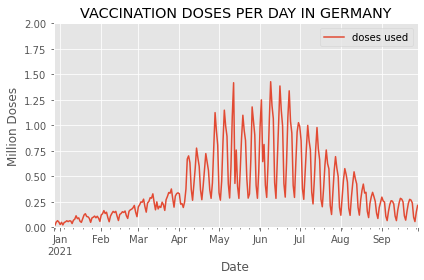

In [98]:
doses_daily.plot(
    ylim=(0,math.ceil(max_doses_daily)),
    xlabel='Date',
    ylabel='Million Doses',
    title='VACCINATION DOSES PER DAY IN GERMANY')

### Doses per Weekday (in the last 6 weeks)

In [99]:
last_6_weeks = doses.tail(42)

In [100]:
# Yields a warning, but exactly like the docs prescribe and it works
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/05_add_columns.html
last_6_weeks['weekday'] = last_6_weeks['date'].dt.day_name()

<ipython-input-100-45013977109e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_6_weeks['weekday'] = last_6_weeks['date'].dt.day_name()


In [101]:
# check:
last_6_weeks.tail(3)

,date,doses used,weekday
273,2021-09-26,0.055119,Sunday
274,2021-09-27,0.147331,Monday
275,2021-09-28,0.213506,Tuesday


In [102]:
# drop the date column
last_6_weeks = last_6_weeks.drop(labels=['date'], axis=1)

In [103]:
#last_6_weeks.set_index('weekday', inplace=True)
last_6_weeks.tail(3)

,doses used,weekday
273,0.055119,Sunday
274,0.147331,Monday
275,0.213506,Tuesday


In [104]:
pivot_table =last_6_weeks.pivot(columns='weekday', values='doses used')
pivot_table.tail()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
271,0.238211,NaN,NaN,NaN,NaN,NaN,NaN
272,NaN,NaN,0.098493,NaN,NaN,NaN,NaN
273,NaN,NaN,NaN,0.055119,NaN,NaN,NaN
274,NaN,0.147331,NaN,NaN,NaN,NaN,NaN
275,NaN,NaN,NaN,NaN,NaN,0.213506,NaN


In [105]:
# Reorder the columns
pivot_table = pivot_table[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
# Rename the columns
pivot_table.columns=['Mo', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pivot_table.tail()

,Mo,Tue,Wed,Thu,Fri,Sat,Sun
271,NaN,NaN,NaN,NaN,0.238211,NaN,NaN
272,NaN,NaN,NaN,NaN,NaN,0.098493,NaN
273,NaN,NaN,NaN,NaN,NaN,NaN,0.055119
274,0.147331,NaN,NaN,NaN,NaN,NaN,NaN
275,NaN,0.213506,NaN,NaN,NaN,NaN,NaN


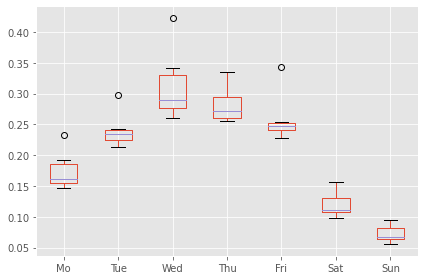

In [106]:
weekday_boxplot = pivot_table.boxplot()

In [107]:
fig = weekday_boxplot.get_figure()
fig.savefig('img/weekday_boxplot.png')

### Doses per Week

In [108]:
# W-Mon in order to start the week on a Monday, see:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets
doses_weekly = doses.groupby(pd.Grouper(key='date',freq='W-Mon')).sum()
doses_weekly.columns = ['million doses used']
doses_weekly.tail()

,million doses used
date,
2021-09-06,1.369795
2021-09-13,1.305806
2021-09-20,1.382219
2021-09-27,1.312216
2021-10-04,0.213506


In [109]:
# What is the highest number of doses used in a week?
max_million_doses_weekly = max(doses_weekly['million doses used'])
max_million_doses_weekly

6.123110999999999

<AxesSubplot:title={'center':'VACCINATION DOSES PER WEEK IN GERMANY\n(until 2021-09-28)'}, xlabel='Date', ylabel='Million Doses'>

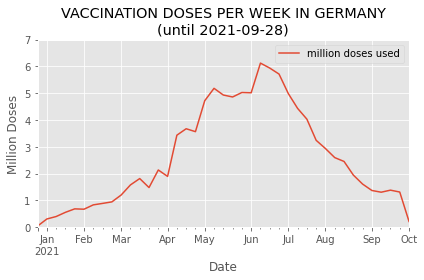

In [110]:
doses_weekly.plot(
    ylim=(0, math.ceil(max_million_doses_weekly)),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER WEEK IN GERMANY\n(until {last_update})")

### Doses per Month

In [111]:
# M = month end frequency
doses_monthly = doses.groupby(pd.Grouper(key='date',freq='M')).sum()
doses_monthly.tail()

,doses used
date,
2021-05-31,21.053696
2021-06-30,24.751592
2021-07-31,17.253469
2021-08-31,9.260628
2021-09-30,5.340262


In [112]:
max_doses_monthly = max(doses_monthly['doses used'])
max_doses_monthly
doses_monthly['month'] = doses_monthly.index.strftime('%B')
doses_monthly['year'] =  doses_monthly.index.strftime('%Y')
doses_monthly['label'] = doses_monthly['month'] + ' ' + doses_monthly['year']
doses_monthly.drop(columns=['month', 'year'], inplace=True)
doses_monthly.set_index('label', inplace=True)
doses_monthly.tail(6)

,doses used
label,
April 2021,15.564447
May 2021,21.053696
June 2021,24.751592
July 2021,17.253469
August 2021,9.260628
September 2021,5.340262


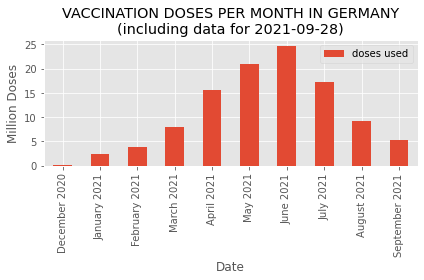

In [113]:
monthly_plot = doses_monthly.plot.bar(
    ylim=(0,math.ceil(max_doses_monthly) + 1),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER MONTH IN GERMANY\n(including data for {last_update})")

In [114]:
fig = monthly_plot.get_figure()
fig.savefig('img/monthly_doses_germany.png')

## Vaccination Campaign Progress

In [115]:
doses_cumulative = vaccinations.loc[ : , ['date', 'partly vaccinated', 'fully vaccinated']]
doses_cumulative.set_index('date', inplace=True)
doses_cumulative.tail(3)

,partly vaccinated,fully vaccinated
date,,
2021-09-26,3.71,64.02
2021-09-27,3.67,64.11
2021-09-28,3.63,64.24


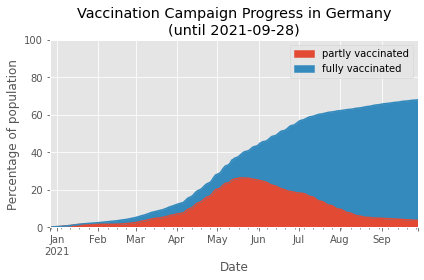

In [116]:
doses_area_plot = doses_cumulative.plot.area(
    ylim=(0,100),
    xlabel='Date',
    ylabel='Percentage of population',
    title=f"Vaccination Campaign Progress in Germany\n(until {last_update})")

In [117]:
fig = doses_area_plot.get_figure()
fig.savefig('img/vaccinations_germany_area_plot.png')

### As of Today

In [118]:
# get the last line of the data
current_state = doses_cumulative.iloc[-1]
current_state

partly vaccinated     3.63
fully vaccinated     64.24
Name: 2021-09-28 00:00:00, dtype: float64

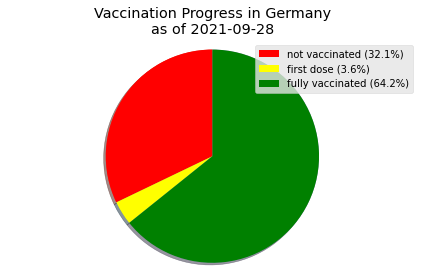

In [119]:
percentage_not_vacc = 100 - current_state['partly vaccinated'] - current_state['fully vaccinated']
labels = [f"not vaccinated ({round(percentage_not_vacc, 1)}%)",
          f"first dose ({round(current_state['partly vaccinated'], 1)}%)",
          f"fully vaccinated ({round(current_state['fully vaccinated'], 1)}%)"]
colors = ['red', 'yellow', 'green']
sizes = [percentage_not_vacc,
         current_state['partly vaccinated'],
         current_state['fully vaccinated']]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title(f"Vaccination Progress in Germany\nas of {last_update}")
# plt.savefig must be before show()
# BEWARE plt.savefig must be in the same Jupyter code cell that creates the graph!
# See comment by ijoseph here:
# https://stackoverflow.com/questions/9012487/matplotlib-pyplot-savefig-outputs-blank-image
plt.savefig('img/vaccination_in_germany_pie.png', bbox_inches='tight')
plt.show()

## Vaccines in Use

In [120]:
vaccinations.columns

Index(['date', 'dosen_kumulativ', 'dosen_biontech_kumulativ',
       'dosen_biontech_dritt_kumulativ', 'dosen_moderna_kumulativ',
       'dosen_moderna_dritt_kumulativ', 'dosen_astra_kumulativ',
       'dosen_astra_dritt_kumulativ', 'dosen_johnson_kumulativ',
       'dosen_erst_kumulativ', 'dosen_zweit_kumulativ',
       'dosen_dritt_kumulativ', 'dosen_differenz_zum_vortag',
       'dosen_erst_differenz_zum_vortag', 'dosen_zweit_differenz_zum_vortag',
       'dosen_dritt_differenz_zum_vortag', 'personen_erst_kumulativ',
       'personen_voll_kumulativ', 'personen_auffrisch_kumulativ',
       'dosen_dim_kumulativ', 'dosen_kbv_kumulativ', 'partly vaccinated',
       'fully vaccinated'],
      dtype='object')

In [121]:
vaccine_use = vaccinations.loc[ : , ['date', 'dosen_biontech_kumulativ',
                                     'dosen_moderna_kumulativ',
                                     'dosen_astra_kumulativ',
                                     'dosen_johnson_kumulativ']]
# Rename columns
vaccine_use.columns = ['date', 'BioNTech', 'Moderna', 'AstraZeneca', 'Johnson & Johnson']
# make 'date' an index
vaccine_use.set_index('date', inplace=True)
# divide columns by 1 million
vaccine_use["BioNTech"] = vaccine_use["BioNTech"] / 1_000_000
vaccine_use["Moderna"] = vaccine_use["Moderna"] / 1_000_000
vaccine_use["AstraZeneca"] = vaccine_use["AstraZeneca"] / 1_000_000
vaccine_use["Johnson & Johnson"] = vaccine_use["Johnson & Johnson"] / 1_000_000
vaccine_use.tail(3)

,BioNTech,Moderna,AstraZeneca,Johnson & Johnson
date,,,,
2021-09-26,81.576880,9.646470,12.685990,3.152805
2021-09-27,81.709452,9.652533,12.686969,3.160522
2021-09-28,81.908841,9.657753,12.687737,3.168651


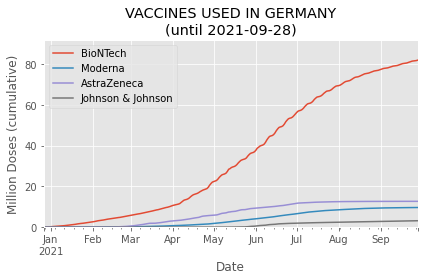

In [122]:
vaccines_used = vaccine_use.plot(
    # as it is cumulative, the last row must contain the single highest number
    ylim=(0,math.ceil(max(vaccine_use.iloc[-1]))+10),
    xlabel='Date',
    ylabel='Million Doses (cumulative)',
    title=f"VACCINES USED IN GERMANY\n(until {last_update})")

In [123]:
fig = vaccines_used.get_figure()
fig.savefig('img/vaccines_used_in_germany.png')

# Vaccination Centers versus Doctor’s Practices

In [124]:
vaccinations.tail()

,date,dosen_kumulativ,dosen_biontech_kumulativ,dosen_biontech_dritt_kumulativ,dosen_moderna_kumulativ,dosen_moderna_dritt_kumulativ,dosen_astra_kumulativ,dosen_astra_dritt_kumulativ,dosen_johnson_kumulativ,dosen_erst_kumulativ,...,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_dritt_differenz_zum_vortag,personen_erst_kumulativ,personen_voll_kumulativ,personen_auffrisch_kumulativ,dosen_dim_kumulativ,dosen_kbv_kumulativ,partly vaccinated,fully vaccinated
271,2021-09-24,106908533,81445207,562314,9636614,25535,12685874,81,3140838,56301150,...,80186,120740,37285,56301150,53159626,588595,0,0,3.78,63.89
272,2021-09-25,107007026,81529446,570346,9642656,26313,12685958,82,3148966,56333288,...,32138,57539,8816,56333288,53225293,597411,0,0,3.74,63.97
273,2021-09-26,107062145,81576880,575730,9646470,26736,12685990,82,3152805,56350512,...,17224,32086,5809,56350512,53261218,603220,0,0,3.71,64.02
274,2021-09-27,107209476,81709452,602075,9652533,27602,12686969,82,3160522,56398158,...,47646,72464,27221,56398158,53341399,630441,0,0,3.67,64.11
275,2021-09-28,107422982,81908841,645200,9657753,28938,12687737,85,3168651,56467517,...,69359,99683,44464,56467517,53449211,674905,0,0,3.63,64.24


In [125]:
by_place = vaccinations.loc[ : , ['date', 'dosen_dim_kumulativ', 'dosen_kbv_kumulativ']]
by_place.columns = ['date', 'vaccination centers', 'practices']

In [126]:
by_place['vaccination centers daily'] = by_place['vaccination centers'].diff()
by_place['practices daily'] = by_place['practices'].diff()

In [127]:
by_place['percentage practices'] =  round(
    by_place['practices daily'] * 100 / 
    (by_place['vaccination centers daily'] + by_place['practices daily']), 2)

by_place['percentage centers'] = 100 - by_place['percentage practices']

In [128]:
# make 'date' an index
by_place.set_index('date', inplace=True)

In [129]:
by_place

,vaccination centers,practices,vaccination centers daily,practices daily,percentage practices,percentage centers
date,,,,,,
2020-12-27,0,0,NaN,NaN,NaN,NaN
2020-12-28,0,0,0.0,0.0,NaN,NaN
2020-12-29,0,0,0.0,0.0,NaN,NaN
2020-12-30,0,0,0.0,0.0,NaN,NaN
2020-12-31,0,0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...
2021-09-24,0,0,0.0,0.0,NaN,NaN
2021-09-25,0,0,0.0,0.0,NaN,NaN
2021-09-26,0,0,0.0,0.0,NaN,NaN


In [130]:
share = by_place.loc[ : , ['percentage centers', 'percentage practices']]

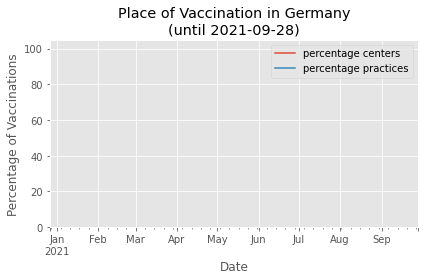

In [131]:
vacc_shares = share.plot(
    # as it is cumulative, the last row must contain the single highest number
    ylim=(0, 105),  # above 100 to see the line
    xlabel='Date',
    ylabel='Percentage of Vaccinations',
    title=f"Place of Vaccination in Germany\n(until {last_update})")

In [132]:
fig = vacc_shares.get_figure()
fig.savefig('img/vaccinations_germany_by_place.png')

## Other units of Time

In [133]:
by_place_daily = by_place.loc[ : , ['vaccination centers daily', 'practices daily']]
by_place_daily.columns = ['vaccination centers', 'practices']
by_place_daily.reset_index(inplace=True)

### Monthly

In [134]:
by_place_monthly = by_place_daily.groupby(pd.Grouper(key='date',freq='M')).sum()
by_place_monthly.tail()

,vaccination centers,practices
date,,
2021-05-31,0.0,0.0
2021-06-30,0.0,0.0
2021-07-31,0.0,0.0
2021-08-31,0.0,0.0
2021-09-30,0.0,0.0


Scale:

In [135]:
by_place_monthly['vaccination centers'] = by_place_monthly['vaccination centers'] / 1_000_000
by_place_monthly['practices'] = by_place_monthly['practices'] / 1_000_000

Rename the columns

In [136]:
by_place_monthly['month'] = by_place_monthly.index.strftime('%B')
by_place_monthly['year'] =  by_place_monthly.index.strftime('%Y')
by_place_monthly['label'] = by_place_monthly['month'] + ' ' + by_place_monthly['year']
by_place_monthly.drop(columns=['month', 'year'], inplace=True)
by_place_monthly.set_index('label', inplace=True)
by_place_monthly.tail(6)

,vaccination centers,practices
label,,
April 2021,0.0,0.0
May 2021,0.0,0.0
June 2021,0.0,0.0
July 2021,0.0,0.0
August 2021,0.0,0.0
September 2021,0.0,0.0


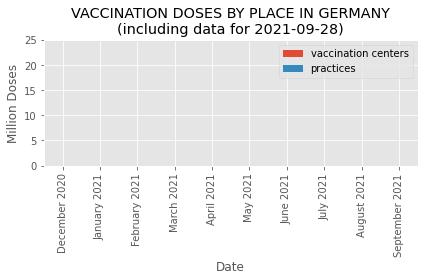

In [137]:
monthly_plot = by_place_monthly.plot.bar(
    stacked=True,
    ylim=(0, 25),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES BY PLACE IN GERMANY\n(including data for {last_update})")

In [138]:
fig = monthly_plot.get_figure()
fig.savefig('img/monthly_doses_by_place_germany.png')